In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, Activation, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Deconv2D
from keras.losses import MSE
import os
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.utils import np_utils
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import utils
%matplotlib inline
%load_ext autoreload
%autoreload 2

from bayes_opt import BayesianOptimization


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Dataset 
Alligned & Cropped version of CelebA 
https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADSNUu0bseoCKuxuI5ZeTl1a/Img?dl=0&preview=img_align_celeba.zip

In [2]:
data_folder = 'img_align_celeba/'

In [3]:
# sample images 
plt.figure(figsize=(10, 10))
for i in range(1, 26):
    filename = os.path.join(data_folder, '{:06d}.jpg'.format(i+3000))
    img = plt.imread(filename)[50:-35:2, 25:-25:2]
    plt.subplot(5, 5, i)
    plt.imshow(img)
    plt.axis('off')

FileNotFoundError: [Errno 2] No such file or directory: 'img_align_celeba/003001.jpg'

## load pretrained vae model weight with latent dimension=8

In [4]:
sess = tf.InteractiveSession()
K.set_session(sess)

In [5]:
latent_size=8

In [6]:
vae, encoder, decoder = utils.create_vae(batch_size=128, latent=latent_size)
sess.run(tf.global_variables_initializer())
vae.load_weights('CelebA_VAE_small_8.h5')

/Users/luliu/Desktop/my_machine_learning_projects/facial_composition/facial_composition/utils.py:57: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding="same", use_bias=False)`
  encoder.add(Conv2D(filters=base_filters*2**i, kernel_size=(5, 5), strides=(2, 2), padding='same', bias=False))
/Users/luliu/Desktop/my_machine_learning_projects/facial_composition/facial_composition/utils.py:57: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding="same", use_bias=False)`
  encoder.add(Conv2D(filters=base_filters*2**i, kernel_size=(5, 5), strides=(2, 2), padding='same', bias=False))
/Users/luliu/Desktop/my_machine_learning_projects/facial_composition/facial_composition/utils.py:57: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding="same", use_bias=False)`
  encoder.add(Conv2D(filt

In [7]:
K.set_learning_phase(False)

In [8]:
latent_placeholder = tf.placeholder(tf.float32, (1, latent_size))
decode = decoder(latent_placeholder)

## draw some samples from the trained latent space 

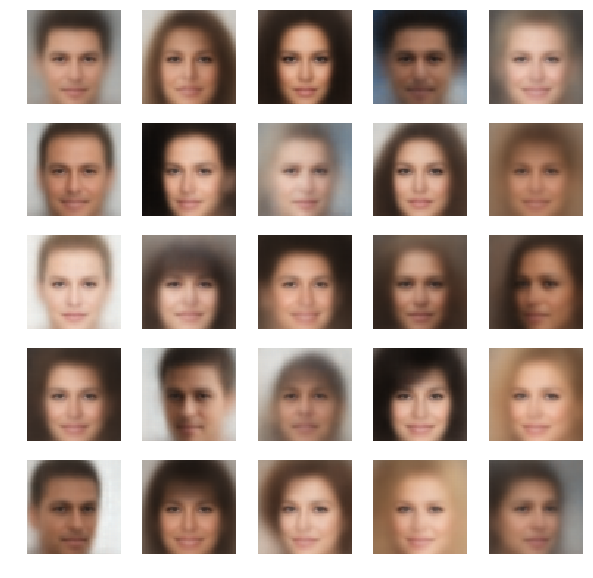

In [9]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    image = sess.run(decode, feed_dict={latent_placeholder: np.random.normal([0]*latent_size,[1]*latent_size)[np.newaxis, :]})[0]
    plt.imshow(np.clip(image, 0, 1))
    plt.axis('off')

In [10]:
class FacialComposit:
    def __init__(self, decoder, latent_size):
        self.latent_size = latent_size
        self.latent_placeholder = tf.placeholder(tf.float32, (1, latent_size))
        self.decode = decoder(self.latent_placeholder)
        self.image_pool = None
        self.ratings = None
        self.samples=None

    def _get_image(self, latent):
        img = sess.run(self.decode, 
                       feed_dict={self.latent_placeholder: latent[np.newaxis,:]})[0]
        img = np.clip(img, 0, 1)
        return img

    @staticmethod
    def _show_images(images, titles):
        assert len(images) == len(titles)
        plt.figure(figsize=(3*len(images), 3))
        n = len(titles)
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(images[i])
            plt.title(str(titles[i]))
            plt.axis('off')
        plt.show()



    def query_initial(self, n_start=9):
        '''
        Creates initial points for Bayesian optimization
        Generate *n_start* random images and asks user pick the best and worst image. 
        '''
        samples = np.random.normal([0]*self.latent_size,[1]*self.latent_size, (n_start, self.latent_size))
        images = np.array([self._get_image(samples[i]) for i in range(n_start)])
        self._show_images(images, ["Image "+str(i) for i in range(n_start)])
        print("Please select the image that's most SIMILAR to your desired image")
        best=int(input())
        print ("please selec the image that's most DISSIMILAR to your desired image")
        worst=int(input())
        self.image_pool = np.array([images[best],images[worst]])
        self.ratings=np.array([80,10])
        self.samples=np.array([samples[best],samples[worst]])
        # Check that tensor sizes are correct
        np.testing.assert_equal(self.samples.shape,[2,self.latent_size])
        np.testing.assert_equal(self.ratings.shape, [2])
        np.testing.assert_equal(self.image_pool.shape, [2, 64, 64, 3])
        
    def get_rating(self,candidate_image):
        #clear_output()
        n=len(self.image_pool)
        # show images for top 5 images in the image pool as a reference for new rating 
        show_img_index=np.argsort(self.ratings)[-min(5,n):]
        self._show_images(self.image_pool[show_img_index],['Image '+str(i) for i in show_img_index])
        print ('current ratings:',self.ratings[show_img_index])
        self._show_images([candidate_image],['candidate'])
        print ('please enter a rating for candidate image based on existing ratings')
        rating=float(input())
        while rating in self.ratings:
            rating+=1 
        return rating
    
    def evaluate(self,  **kwargs):
        candidate=np.array([kwargs['z_{0:03d}'.format(i)] for i in range(self.latent_size)])
        '''
        Queries candidate vs known image set.
        Adds candidate into images pool.
        :params candidate a latent vector with shape (1,latent_size) 
        '''
        initial_size = len(self.image_pool)
        ## Show user an image and ask to assign score to it.
        candidate_image=self._get_image(candidate)
        candidate_rating = self.get_rating(candidate_image)
        self.image_pool=np.append(self.image_pool,candidate_image[np.newaxis,:],axis=0)
        self.ratings=np.append(self.ratings,candidate_rating)
        assert len(self.image_pool) == initial_size + 1
        assert len(self.ratings) == initial_size + 1
        return candidate_rating

    def optimize(self, n_iter=10, w=2):
        if self.image_pool is None:
            self.query_initial()
        bounds = {'z_{0:03d}'.format(i): (-w, w) for i in range(self.latent_size)}
        bo = BayesianOptimization(self.evaluate, bounds)
        init_vals={'z_{0:03d}'.format(i): self.samples[:,i] for i in range(self.latent_size)}
        init_vals['target']=self.ratings
        bo.initialize(init_vals)
        # init_points: number of random initial points. 
        bo.maximize(init_points=0, n_iter=10,acq='ei', kappa=3)
        self.draw_best()
    def draw_best(self, title='Best Image'):
        index_best = np.argmax(self.ratings)
        image = self.image_pool[index_best]
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()

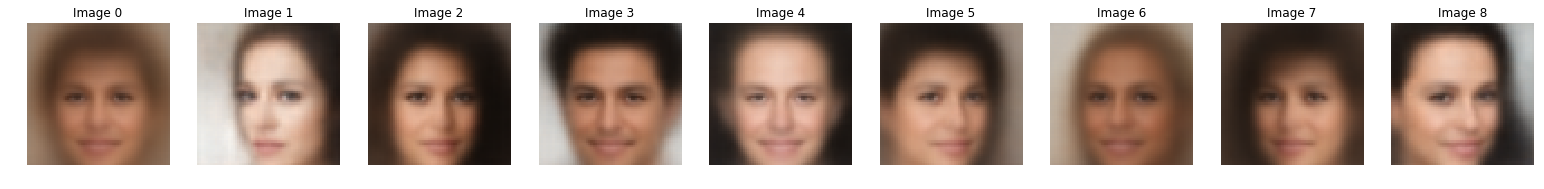

Please select the image that's most SIMILAR to your desired image
3 
please selec the image that's most DISSIMILAR to your desired image
1
Initialization
-----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     z_000 |     z_001 |     z_002 |     z_003 |     z_004 |     z_005 |     z_006 |     z_007 | 
    1 | 00m00s |   80.00000 |   -0.1173 |    0.3128 |    0.4483 |   -1.1837 |   -1.6780 |   -2.2181 |    0.3815 |    0.7658 | 
    2 | 00m00s |   10.00000 |    0.7262 |    1.2464 |   -0.4909 |   -2.9871 |   -0.5068 |    0.2450 |   -1.3083 |    2.6550 | 
Bayesian Optimization
-----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     z_000 |     z_001 |     z_002 |     z_003 |     z_004 |     z_005 |     z_006 |     z_007 | 


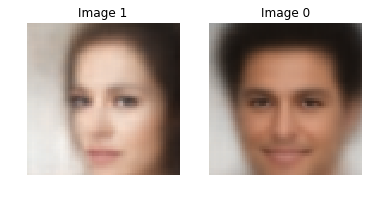

current ratings: [10 80]


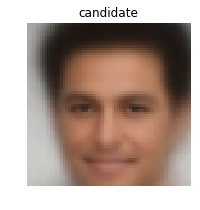

please enter a rating for candidate image based on existing ratings
60
    3 | 02m12s |   60.00000 |   -0.3919 |    0.3908 |    0.8120 |   -1.1076 |   -1.5460 |   -1.8522 |    0.4443 |    0.5326 | 


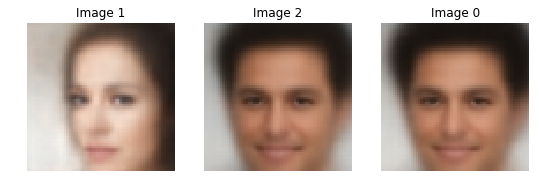

current ratings: [10. 60. 80.]


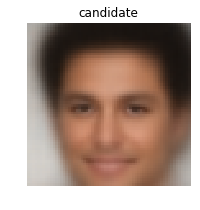

please enter a rating for candidate image based on existing ratings
85
    4 | 00m10s |   85.00000 |    0.0453 |    0.2005 |    0.4206 |   -1.4132 |   -1.1134 |   -1.9927 |    0.4376 |    0.8189 | 


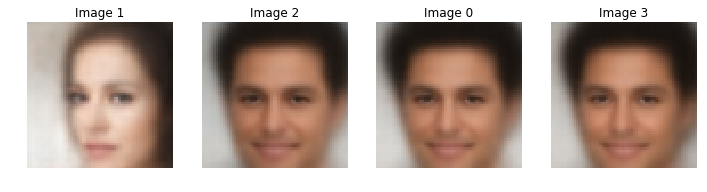

current ratings: [10. 60. 80. 85.]


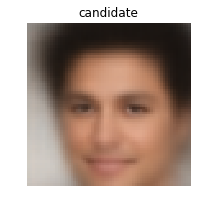

please enter a rating for candidate image based on existing ratings
80
    5 | 00m08s |   81.00000 |   -0.2272 |    0.2421 |   -0.1800 |   -1.6479 |   -1.4482 |   -1.8093 |    0.1259 |    0.7472 | 


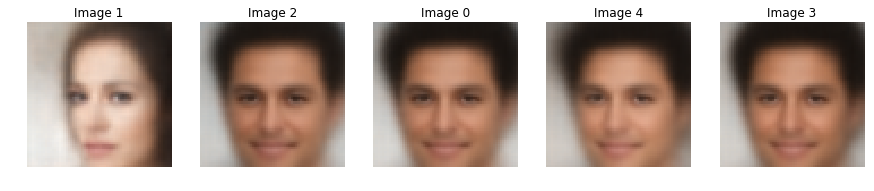

current ratings: [10. 60. 80. 81. 85.]


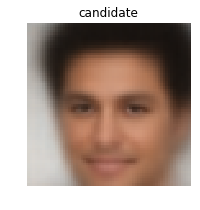

please enter a rating for candidate image based on existing ratings
309
    6 | 00m04s |  309.00000 |    0.0605 |    0.3821 |    0.2894 |   -1.5983 |   -1.4662 |   -1.8300 |    0.5988 |    0.5670 | 


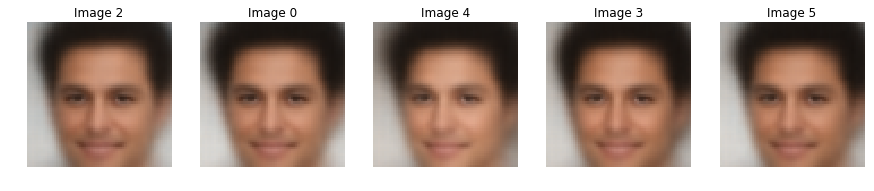

current ratings: [ 60.  80.  81.  85. 309.]


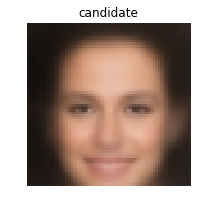

please enter a rating for candidate image based on existing ratings
500
    7 | 00m05s |  500.00000 |   -0.4320 |   -1.2763 |    1.3754 |    1.3070 |   -0.3662 |   -0.2272 |   -1.5098 |    1.1205 | 


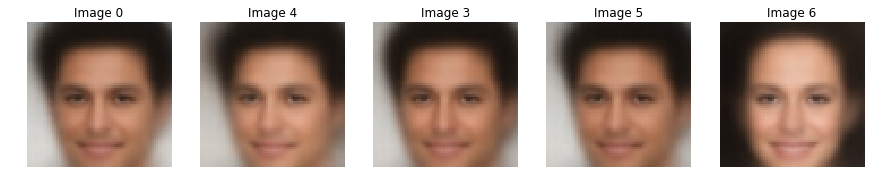

current ratings: [ 80.  81.  85. 309. 500.]


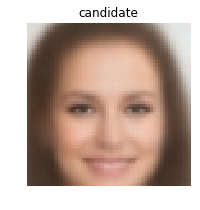

please enter a rating for candidate image based on existing ratings
600
    8 | 00m08s |  600.00000 |   -0.4718 |    0.2986 |    1.8571 |    1.0094 |    1.8624 |   -0.4373 |   -1.2419 |    1.9480 | 


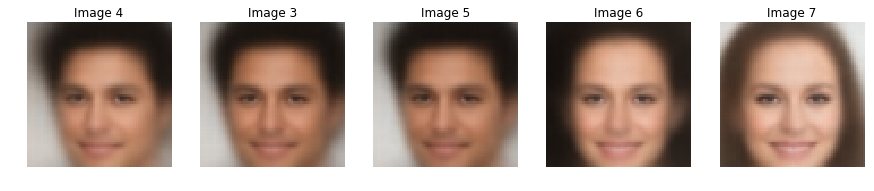

current ratings: [ 81.  85. 309. 500. 600.]


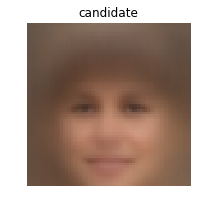

please enter a rating for candidate image based on existing ratings
40
    9 | 00m04s |   40.00000 |   -0.5012 |   -0.1031 |   -1.4164 |    0.0371 |   -0.5697 |    0.6389 |    0.8085 |   -0.1920 | 


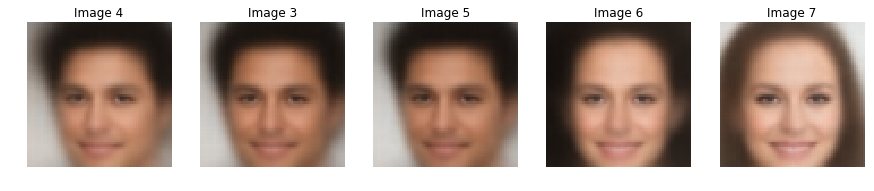

current ratings: [ 81.  85. 309. 500. 600.]


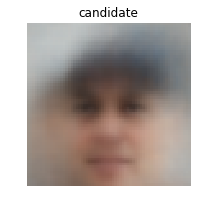

please enter a rating for candidate image based on existing ratings
3
   10 | 00m03s |    3.00000 |   -0.9253 |    1.2779 |   -1.6841 |   -0.1075 |   -1.1714 |    0.9034 |    1.4313 |   -1.2875 | 


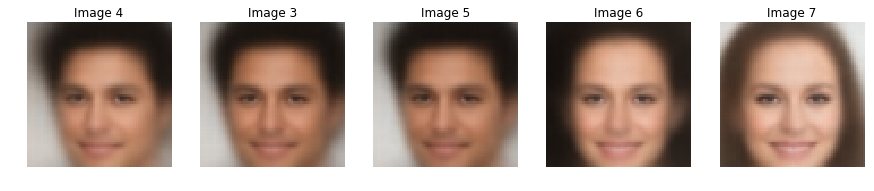

current ratings: [ 81.  85. 309. 500. 600.]


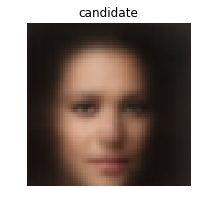

please enter a rating for candidate image based on existing ratings
1
   11 | 00m04s |    1.00000 |    1.3281 |   -1.8571 |    1.5117 |    1.9415 |   -0.0017 |    0.6565 |    0.6007 |   -1.7174 | 


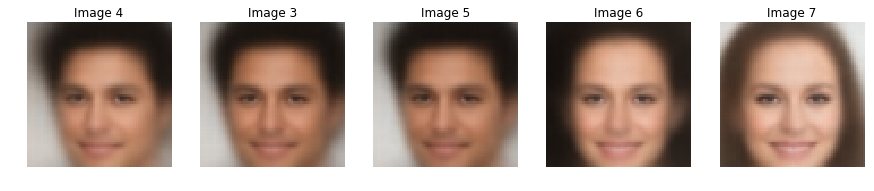

current ratings: [ 81.  85. 309. 500. 600.]


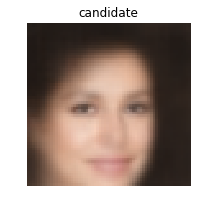

please enter a rating for candidate image based on existing ratings
400
   12 | 05m09s |  400.00000 |    1.4126 |   -1.2777 |   -1.7908 |    1.4755 |   -0.0694 |   -0.6306 |   -1.1268 |    1.9277 | 


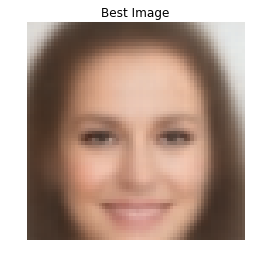

In [12]:
composit = FacialComposit(decoder, 8)
composit.optimize()